<a href="https://colab.research.google.com/github/OussamaBOUDCHICHI/On-the-Epps-effect/blob/main/EppsEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# On the Epps effect and its relationship to asynchronous trading 
## Authors : BOUDCHICHI Oussama & MAARAF Oumayma
### $\color{darkred}{\text{Note}}$ :

- Please $\color{darkblue}{\text{import}}$ the folder containing all the necessary and change the path bellow (base_dir) with its corresponding path. 

- $\color{darkblue}{\text{Ensure}}$ that the Exécution time is set to GPU : 

```Exécution -> Modifier le type d'exécution -> Accélérateur matériel -> GPU```


In [5]:
# Change this with the folder's path
base_dir = '/content/drive/MyDrive/Colab Notebooks/src'

import os
os.chdir(base_dir)

In [6]:
from numba import jit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [39]:
from plotTools import config
config(dpi = 1.5 * 100)

In [10]:
days = ["2019-05-02", "2019-05-03", "2019-05-06", "2019-05-07", "2019-05-09", "2019-05-10", "2019-05-13", "2019-05-14",
        "2019-05-15", "2019-05-16", "2019-05-17", "2019-05-20", "2019-05-21", "2019-05-22", "2019-05-23", "2019-05-24",
        "2019-05-27", "2019-05-28", "2019-05-29", "2019-05-30", "2019-05-31", "2019-06-03", "2019-06-04", "2019-06-05",
        "2019-06-06", "2019-06-07", "2019-06-10", "2019-06-11", "2019-06-12", "2019-06-13", "2019-06-14", "2019-06-18",
        "2019-06-19", "2019-06-20", "2019-06-21", "2019-06-24", "2019-06-25", "2019-06-26", "2019-06-27", "2019-06-28"]

In [11]:
cols = ['BTI', 'NPN', 'AGL']
data = pd.DataFrame()
for day in days:
    d = pd.read_csv('./12315092/JSE_' + day + '.csv')
    d['dt'] = d['Date'].apply(lambda x: datetime.fromtimestamp(x))
    data = pd.concat([data, d[['dt'] + cols]], ignore_index=True)
data.index = data['dt']
data.drop('dt', axis = 1, inplace = True)

In [12]:
lrets = data.pct_change().apply(lambda x: np.log(1. + x))

In [13]:
def compCrossCorr(data, *tickers, interval):
    d = data[list(tickers)].resample(str(interval) + 'S').sum()
    rho = np.corrcoef(d[tickers[0]], d[tickers[1]])[0, 1]
    return rho

In [14]:
def rescale(t):
    t_max = t.max()
    t_min = t.min()
    return np.array(2. * np.pi * (t - t_min) / (t_max - t_min))

In [16]:
def prepareForNumba(Data, Synchronize = False):
  DATA = Data.copy()
  if Synchronize: DATA = DATA.dropna()
  else: DATA.fillna(0., inplace = True)

  cols = DATA.columns
  DATA['t'] = rescale(DATA.index)
  DATA = DATA[['t', cols[0], cols[1]]]
  return DATA.values

In [17]:
# % Maliavin-Mancino estimator
@jit(nopython = True)
def MaliavinMancino(DATA, M):
    assert(DATA.shape[1] == 3)

    t = DATA[:, 0]
    a = np.zeros((M, 2))
    b = np.zeros((M, 2))
    
    for q in range(a.shape[0]):
       a[q, 0] = ((DATA[-1, 1] - DATA[0, 1]) / np.pi) + (1. /np.pi) * np.array([(np.cos(q * t[i]) - np.cos(q * t[i - 1])) * DATA[i, 1] for i in range(1, len(t))]).sum()
       a[q, 1] = ((DATA[-1, 2] - DATA[0, 2]) / np.pi) + (1. /np.pi) * np.array([(np.cos(q * t[i]) - np.cos(q * t[i - 1])) * DATA[i, 2] for i in range(1, len(t))]).sum()
       
       b[q, 0] = (1. /np.pi) * np.array([(np.sin(q * t[i]) - np.sin(q * t[i - 1])) * DATA[i, 1] for i in range(1, len(t))]).sum()
       b[q, 1] = (1. /np.pi) * np.array([(np.sin(q * t[i]) - np.sin(q * t[i - 1])) * DATA[i, 2] for i in range(1, len(t))]).sum()
    
    sigma_ij = (2. * np.pi **2 / M) * (a[:, 0] * a[:, 1] + b[:, 0] * b[:, 1]).sum()
    sigma_i = (2. * np.pi **2 / M) * (a[:, 0] * a[:, 0] + b[:, 0] * b[:, 0]).sum()
    sigma_j = (2. * np.pi **2 / M) * (a[:, 1] * a[:, 1] + b[:, 1] * b[:, 1]).sum()

    try:
        assert((sigma_i != 0.) & (sigma_j != 0.))
        print('One of the vriance values is equal to 0. Shifting with 1e-10 ... ')

    except Exception:
        sigma_i = sigma_i + 1e-10
        sigma_j = sigma_j + 1e-10
    
    return sigma_ij / np.sqrt(sigma_i * sigma_j)


In [18]:
d = prepareForNumba(lrets.iloc[:, [0, -1]])
M = 20
MM = MaliavinMancino(d, M)
MM

One of the vriance values is equal to 0. Shifting with 1e-10 ... 


0.008206058436301948

In [19]:
# % Hayashi-Yoshida estimator
def HayashiYoshida(price):

  idx1 = np.where(price[:, 1] != 0.)
  idx2 = np.where(price[:, 2] != 0.)
  idx = np.where((price[:, 1] != 0.) & (price[:, 2] != 0.))

  p_1 = np.log(price[idx,  1])
  p_2 = np.log(price[idx,  2])

  cov = (np.diff(p_1) * np.diff(p_2)).sum()
  sig1 = (np.diff(price[idx1, 1]) ** 2).sum()
  sig2 = (np.diff(price[idx2, 2]) ** 2).sum()
  
  return np.clip(cov / np.sqrt(sig1 * sig2), -1., 1.)

In [33]:
idx = [[0, 1], [1, -1], [0, -1]]
HY, MM = [], []
M = 20
for id in idx:
  tst = prepareForNumba(data.iloc[:, id])
  HY.append(HayashiYoshida(tst))
  MM.append(MaliavinMancino(tst, M))

One of the vriance values is equal to 0. Shifting with 1e-10 ... 
One of the vriance values is equal to 0. Shifting with 1e-10 ... 
One of the vriance values is equal to 0. Shifting with 1e-10 ... 


In [34]:
HY, MM

([1.4950218683412036e-12, 1.0662298303987958e-11, 1.303050677101681e-10],
 [-0.08201502887934606, -0.37902583329788375, -0.2548612533171013])

In [21]:
dt = np.arange(1, 8000, 50)
corrs = np.zeros((dt.shape[0], 3))
for i in range(dt.shape[0]):
        corrs[i, 0] = compCrossCorr(data, 'BTI', 'AGL' , interval = dt[i])
        corrs[i, 1] = compCrossCorr(data, 'BTI', 'NPN' , interval = dt[i])
        corrs[i, 2] = compCrossCorr(data, 'AGL', 'NPN' , interval = dt[i])

corrs = pd.DataFrame(corrs, index = dt, columns = ['BTI/AGL', 'BTI/NPN', 'AGL/NPN'])

Text(0.5, 1.0, 'Evolution de la corrélation')

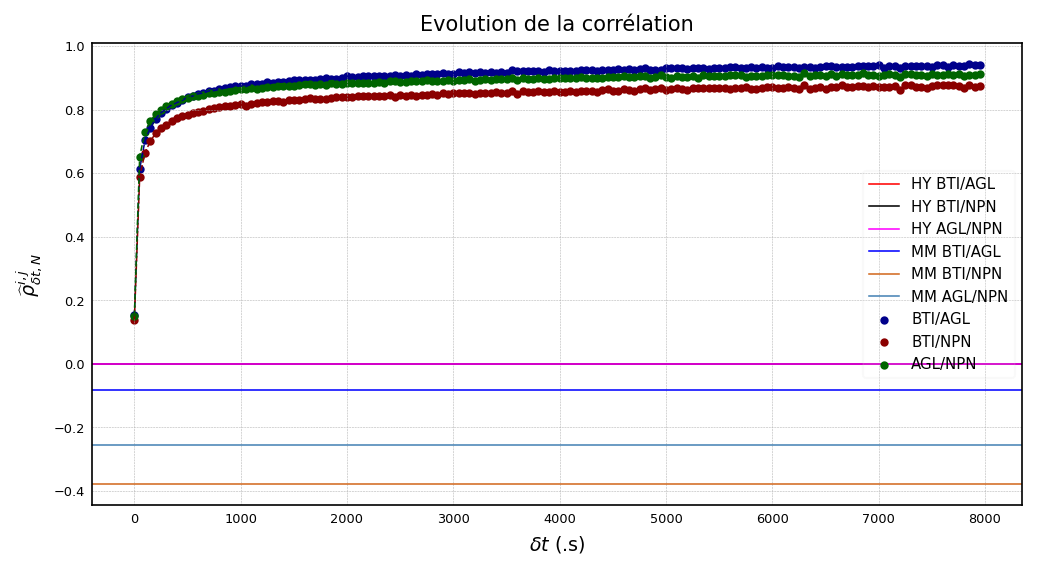

In [50]:
for col in corrs.columns:
    plt.scatter(corrs.index, corrs[[col]], label = col)
    plt.plot(corrs.index, corrs[col], '--')

colors2 = ['blue', 'chocolate', 'steelblue']

[plt.axhline(y = c, label = 'HY ' + lbl, color = cl) for c, lbl, cl in zip(HY, corrs.columns, colors1)]
[plt.axhline(y = c, label = 'MM ' + lbl, color = cl) for c, lbl, cl in zip(MM, corrs.columns, colors2)]
plt.legend()
plt.ylabel(r'$\widehat{\rho}^{i, j}_{\delta t, N}$')
plt.xlabel(r'$\delta t$ (.s)')
# plt.legend(corrs.columns)
plt.title('Evolution de la corrélation')